In [72]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [73]:
# Load the dataset
df = pd.read_csv('Property_Valuation_Data.csv', encoding='Latin-1')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,$39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,$120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,$62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,$95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,$51.00


In [74]:
df.shape

(13320, 9)

In [75]:
df['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [76]:
df['area_type'].value_counts()

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64

In [77]:
# Data Cleaning
df = df.drop(['area_type', 'society', 'balcony', 'availability'], axis='columns')
df = df.dropna()
df

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,$39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,$120.00
2,Uttarahalli,3 BHK,1440,2.0,$62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,$95.00
4,Kothanur,2 BHK,1200,2.0,$51.00
...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453,4.0,231
13316,Richards Town,4 BHK,3600,5.0,400
13317,Raja Rajeshwari Nagar,2 BHK,1141,2.0,60
13318,Padmanabhanagar,4 BHK,4689,4.0,488


In [78]:
df.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [79]:
df.shape

(13246, 5)

In [80]:
df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))
df.bhk.unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [81]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [82]:
df[~df['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186,4
122,Hebbal,4 BHK,3067 - 8156,4.0,? 477.00,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,? 54.01,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,? 43.49,2
188,KR Puram,2 BHK,1015 - 1540,2.0,? 56.80,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.5,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.77,2
648,Arekere,9 Bedroom,4125Perch,9.0,265,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.13,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445,4


#### In above case some data is in range (E.g. 2100-2850) for such cases we have taken average of mean and max values. In some cases values are in form of Sq. Meter which can be converted to sqft

In [83]:
def num_value(x):
    if isinstance(x, str) and '-' in x:
        a, b = x.split('-')
        return (float(a) + float(b)) / 2
    try:
        return float(x)
    except:
        return None


In [84]:
df.total_sqft = df.total_sqft.apply(num_value)
df = df[df.total_sqft.notnull()]
df.head(10)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,$39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,$120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,$62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,$95.00,3
4,Kothanur,2 BHK,1200.0,2.0,$51.00,2
5,Whitefield,2 BHK,1170.0,2.0,$38.00,2
6,Old Airport Road,4 BHK,2732.0,4.0,$204.00,4
7,Rajaji Nagar,4 BHK,3300.0,4.0,$600.00,4
8,Marathahalli,3 BHK,1310.0,3.0,$63.25,3
9,Gandhi Bazar,6 Bedroom,1020.0,6.0,$370.00,6


In [85]:
def price_value(x):
    if isinstance(x, str):
        x = x.replace('$', '')
        if '-' in x:
            a, b = x.split('-')
            try:
                return (float(a) + float(b)) / 2
            except:
                return None
        try:
            return float(x)
        except:
            return None
    try:
        return float(x)
    except:
        return None

In [86]:
df['price']=df['price'].apply(price_value)
df

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4076\3869491859.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price']=df['price'].apply(price_value)


,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2
...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5
13316,Richards Town,4 BHK,3600.0,5.0,400.00,4
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4



Feature Engineering

In [87]:
df['price_per_sqft'] = df['price']*100000/df['total_sqft']
df.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4076\1120918331.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_per_sqft'] = df['price']*100000/df['total_sqft']


,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [88]:
len(df.location.unique())

1298

In [89]:
location_count = df['location'].value_counts()
location_count

location
Whitefield                   532
Sarjapur  Road               392
Electronic City              302
Kanakpura Road               264
Thanisandra                  232
                            ... 
Indiranagar HAL 2nd Stage      1
Maruthi HBCS Layout            1
K R C kothanur                 1
1Channasandra                  1
Abshot Layout                  1
Name: count, Length: 1298, dtype: int64

In [90]:
len(location_count[location_count<10])

1045

In [91]:
location_count_lessthan10 = location_count[location_count<10]
location_count_lessthan10

location
2nd Phase JP Nagar           9
Chandra Layout               9
Yemlur                       9
Kaverappa Layout             9
Banagiri Nagar               9
                            ..
Indiranagar HAL 2nd Stage    1
Maruthi HBCS Layout          1
K R C kothanur               1
1Channasandra                1
Abshot Layout                1
Name: count, Length: 1045, dtype: int64

In [92]:
df['location'] = df.location.apply(lambda x: 'Other' if x in location_count_lessthan10 else x)
len(df.location.unique())

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4076\4070148886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['location'] = df.location.apply(lambda x: 'Other' if x in location_count_lessthan10 else x)


254

In [93]:
df

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
...,...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5,6689.834926
13316,Other,4 BHK,3600.0,5.0,400.00,4,11111.111111
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2,5258.545136
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4,10407.336319


#### Minimum value of a single bhk should be 200 sqft and if we have values like 200 sqft for 2 bhk then it is an outlier and needs to be removed

In [94]:
df['sqft_per_bhk'] = df['total_sqft'] / df['bhk'].round(2)
df[df['sqft_per_bhk'] >= 200].head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4076\3229229776.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sqft_per_bhk'] = df['total_sqft'] / df['bhk'].round(2)


,location,size,total_sqft,bath,price,bhk,price_per_sqft,sqft_per_bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606,528.0
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615,650.0
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556,480.0
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861,507.0
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000,600.0


In [95]:
df.shape

(13200, 8)

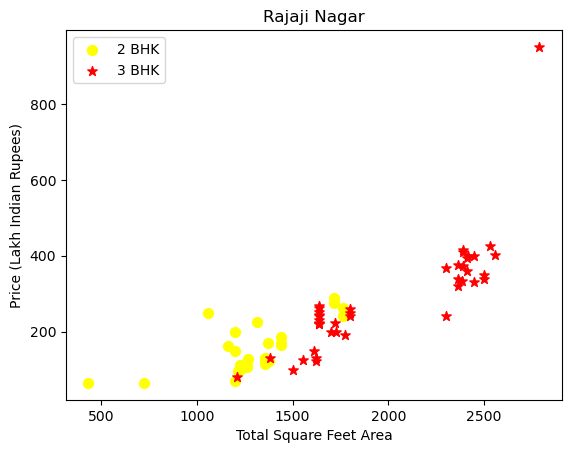

In [96]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    plt.scatter(bhk2.total_sqft,bhk2.price,color='yellow',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='*', color='red',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()

plot_scatter_chart(df,"Rajaji Nagar")

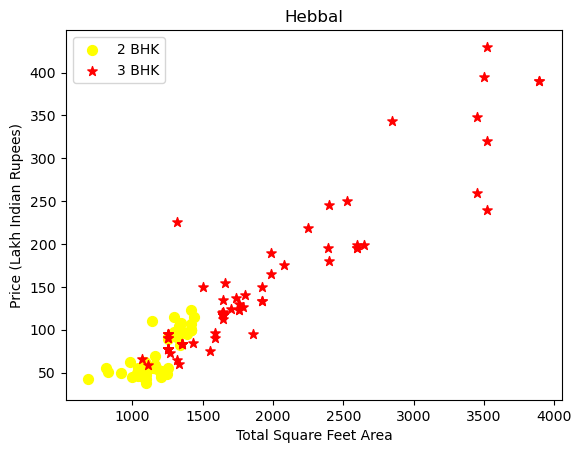

In [97]:
plot_scatter_chart(df,"Hebbal")

#### Now we can remove those 2 bhk apartments whose price_per_sqft is less than the price_per_sqft of 1 bhk apartment

In [98]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

In [99]:
df = remove_bhk_outliers(df)
df

,location,size,total_sqft,bath,price,bhk,price_per_sqft,sqft_per_bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606,528.000000
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556,480.000000
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861,507.000000
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000,600.000000
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101,683.000000
...,...,...,...,...,...,...,...,...
13314,Green Glen Layout,3 BHK,1715.0,3.0,112.00,3,6530.612245,571.666667
13316,Other,4 BHK,3600.0,5.0,400.00,4,11111.111111,900.000000
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2,5258.545136,570.500000
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4,10407.336319,1172.250000


In [100]:
df.shape

(9298, 8)

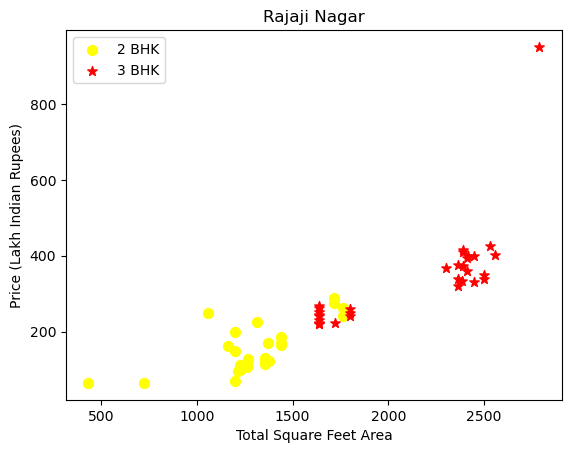

In [101]:
plot_scatter_chart(df,"Rajaji Nagar")

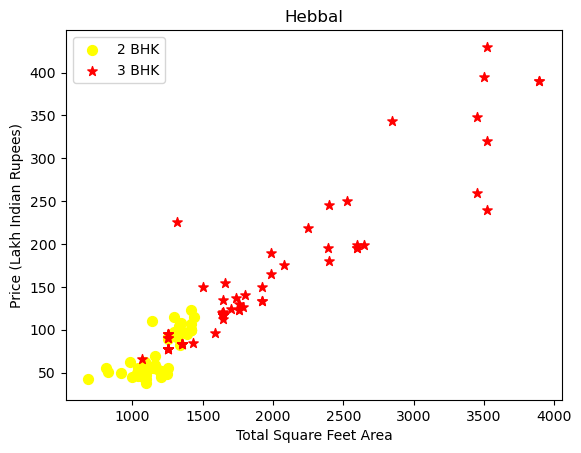

In [102]:
plot_scatter_chart(df,"Hebbal")

In [103]:
df.drop(columns=['size','price_per_sqft','sqft_per_bhk'])

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2
6,Old Airport Road,2732.0,4.0,204.00,4
...,...,...,...,...,...
13314,Green Glen Layout,1715.0,3.0,112.00,3
13316,Other,3600.0,5.0,400.00,4
13317,Raja Rajeshwari Nagar,1141.0,2.0,60.00,2
13318,Padmanabhanagar,4689.0,4.0,488.00,4


One-Hot Encoding for categorical features

In [104]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

In [105]:
# One-Hot Encoding all categorical columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cols = encoder.fit_transform(df[categorical_cols])

In [106]:
# Create a DataFrame for the encoded categorical data
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))

In [107]:
# Drop original categorical columns from df
df = df.drop(columns=categorical_cols)

In [108]:
# Concatenate the encoded categorical data with the numerical data
df_encoded = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

In [109]:
# Drop rows with NaN values
df_encoded = df_encoded.dropna()

In [110]:
# Splitting the data into features and target
X = df_encoded.drop(columns=['price'])
y = df_encoded['price']

In [111]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)

In [112]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Linear Regression

In [113]:
# Linear Regression Model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [114]:
y_train_pred = model.predict(X_train_scaled)

In [115]:
# Evaluate Model for Training Predictions
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

print("Training MSE:", mse_train)
print("Training MAE:", mae_train)
print("Training RMSE:", rmse_train)

Training MSE: 8857.85824597278
Training MAE: 39.25491642099953
Training RMSE: 94.11619544994782


In [116]:
# Test Prediction
y_test_pred = model.predict(X_test_scaled)

In [117]:
# Evaluate Model for Test Predictions
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)

print("Test MSE:", mse_test)
print("Test MAE:", mae_test)
print("Test RMSE:", rmse_test)

Test MSE: 3.6046425801817693e+25
Test MAE: 141591199446.41107
Test RMSE: 6003867570309.799


In [118]:
model_r2 = r2_score(y_test, y_test_pred)
model_r2

-3.5464947596836962e+19

In [119]:
# Comparison of Actual vs Predicted Prices
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
print(comparison_df)

      Actual   Predicted
721     82.0   80.603477
4939    58.0   81.790977
5783    70.0   42.212852
1599    53.0   47.064414
5160   165.0  143.361289
...      ...         ...
2812    98.0  111.923789
4277    78.3   84.290977
7566    46.0   28.486289
1165   200.0  268.427695
3614    52.0   33.126914

[1798 rows x 2 columns]


### Decision Tree

In [120]:
# Initialize and train Decision Tree model
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor()

In [121]:
# Make predictions
dt_y_test_pred = dt_model.predict(X_test_scaled)

In [122]:
# Evaluate the model
dt_r2 = r2_score(y_test, dt_y_test_pred)
dt_mse = mean_squared_error(y_test, dt_y_test_pred)
dt_mae = mean_absolute_error(y_test, dt_y_test_pred)
dt_rmse = np.sqrt(dt_mse)

print("Decision Tree Test R-Squared: ", dt_r2)
print("Decision Tree Test MSE: ", dt_mse)
print("Decision Tree Test MAE: ", dt_mae)
print("Decision Tree Test RMSE: ", dt_rmse)

Decision Tree Test R-Squared:  0.07046481074167221
Decision Tree Test MSE:  944775.7151843993
Decision Tree Test MAE:  27.679382647385985
Decision Tree Test RMSE:  971.995738254237


In [123]:
# Create a DataFrame to compare actual vs predicted values
dt_comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': dt_y_test_pred})
print(dt_comparison_df.head())


      Actual  Predicted
721     82.0      83.00
4939    58.0      58.00
5783    70.0      69.00
1599    53.0      53.58
5160   165.0     170.00


### Random Forest

In [124]:
# Initialize and train Random Forest model
rf_model = RandomForestRegressor()
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor()

In [125]:
# Make predictions
rf_y_test_pred = rf_model.predict(X_test_scaled)

In [126]:
# Evaluate the model
rf_r2 = r2_score(y_test, rf_y_test_pred)
rf_mse = mean_squared_error(y_test, rf_y_test_pred)
rf_mae = mean_absolute_error(y_test, rf_y_test_pred)
rf_rmse = np.sqrt(rf_mse)

print("Random Forest Test R-Squared: ", rf_r2)
print("Random Forest Test MSE: ", rf_mse)
print("Random Forest Test MAE: ", rf_mae)
print("Random Forest Test RMSE: ", rf_rmse)

Random Forest Test R-Squared:  0.09018845242668305
Random Forest Test MSE:  924728.6874932095
Random Forest Test MAE:  26.293087124582858
Random Forest Test RMSE:  961.6281440833611


In [127]:
# Create a DataFrame to compare actual vs predicted values
rf_comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': rf_y_test_pred})
print(rf_comparison_df.head())

      Actual  Predicted
721     82.0    82.3735
4939    58.0    57.9920
5783    70.0    69.6064
1599    53.0    53.2104
5160   165.0   164.7300


#### Hyperparameter Tuning for Decision Tree

In [128]:
# Hyperparameter Tuning with GridSearchCV for Decision Tree
param_grid_dt = {'max_depth': [10, 20]}
grid_search_dt = GridSearchCV(DecisionTreeRegressor(), param_grid_dt, cv=3, scoring='neg_mean_squared_error')
grid_search_dt.fit(X_train_scaled, y_train)

print("Best Decision Tree Parameters:", grid_search_dt.best_params_)
print("Best Decision Tree MSE:", -grid_search_dt.best_score_)

Best Decision Tree Parameters: {'max_depth': 20}
Best Decision Tree MSE: 1558.7143125747807


In [129]:
# Hyperparameter Tuning with GridSearchCV for Random Forest
param_grid_rf = {'n_estimators': [50], 'max_depth': [10, 20]}
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=36), param_grid_rf, cv=3, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train_scaled, y_train)

print("Best Random Forest Parameters:", grid_search_rf.best_params_)
print("Best Random Forest MSE:", -grid_search_rf.best_score_)

Best Random Forest Parameters: {'max_depth': 20, 'n_estimators': 50}
Best Random Forest MSE: 1908.8565080807787


In [130]:
models = {'Linear Regression': model,
          'Decision Tree': dt_model,
          'Random Forest': rf_model}

In [131]:
for name, model in models.items():
    y_test_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    print(f"{name} MSE: {mse}")
    print(f"{name} R2 Score: {r2}")
    print("="*50)

Linear Regression MSE: 3.6046425801817693e+25
Linear Regression R2 Score: -3.5464947596836962e+19
Decision Tree MSE: 944775.7151843993
Decision Tree R2 Score: 0.07046481074167221
Random Forest MSE: 924728.6874932095
Random Forest R2 Score: 0.09018845242668305


In [132]:
# Evaluate the Best Tuned Model on Test Data
best_dt_model = grid_search_dt.best_estimator_
best_rf_model = grid_search_rf.best_estimator_

In [133]:
# Decision Tree Best Model Evaluation
dt_y_test_pred = best_dt_model.predict(X_test_scaled)
dt_mse = mean_squared_error(y_test, dt_y_test_pred)
dt_r2 = r2_score(y_test, dt_y_test_pred)

print(f"Best Decision Tree Model MSE: {dt_mse}")
print(f"Best Decision Tree Model R2 Score: {dt_r2}")

Best Decision Tree Model MSE: 940028.3460164155
Best Decision Tree Model R2 Score: 0.07513559834461092


In [134]:
# Random Forest Best Model Evaluation
rf_y_test_pred = best_rf_model.predict(X_test_scaled)
rf_mse = mean_squared_error(y_test, rf_y_test_pred)
rf_r2 = r2_score(y_test, rf_y_test_pred)

print(f"Best Random Forest Model MSE: {rf_mse}")
print(f"Best Random Forest Model R2 Score: {rf_r2}")

Best Random Forest Model MSE: 929061.0538901805
Best Random Forest Model R2 Score: 0.08592597303181537


In [135]:
# Create a DataFrame to compare actual vs predicted values
comparison_df = pd.DataFrame({'Actual': y_test, 'Best Decision Tree Predicted': dt_y_test_pred, 'Best Random Forest Predicted': rf_y_test_pred})
print(comparison_df.head())

      Actual  Best Decision Tree Predicted  Best Random Forest Predicted
721     82.0                         83.00                     82.360000
4939    58.0                         58.00                     58.055667
5783    70.0                         69.44                     69.484000
1599    53.0                         53.58                     53.383000
5160   165.0                        168.00                    164.520000
